In [1]:
import gzip
import requests
from io import BytesIO, StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.keras
import time
import os
import re
import string
import emoji
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
GITHUB_CLEAN_URL = "https://raw.githubusercontent.com/Bootcamp-IA-P4/project-x-nlp-team-3/feature/models/Data/fusion30.csv"

def load_comments_data_from_github(url):
    """
    Downloading and processing comments data from GitHub repository.
    """
    print("🔗 Downloading data from GitHub...")

    try:
        response = requests.get(url)
        response.raise_for_status()

        print("📊 Reading CSV file...")

        df = pd.read_csv(StringIO(response.text), sep=';')

        print("✅ Data downloaded successfully!")
        return df

    except Exception as e:
        print(f"❌ Error while downloading data: {e}")
        return None

# Creating dataframe from GitHub URL
df = load_comments_data_from_github(GITHUB_CLEAN_URL)

🔗 Downloading data from GitHub...
📊 Reading CSV file...
✅ Data downloaded successfully!


In [3]:
print(df.columns)

Index(['text', 'General_judgement', 'Aligned_with_label', 'Violence (Low)',
       'Violence_judgement', 'Hate (Low)', 'Hate_judgement', 'Sexual (Low)',
       'Sexual_judgement', 'Self-harm (Low)', 'Self-harm_judgement', 'label'],
      dtype='object')


''' Inserccion y limpeza de datos '''

In [4]:
def clean_text(text):
    '''
    Función para realizar una limpieza avanzada del texto:
    - Elimina URLs
    - Convierte emojis a texto
    - Elimina menciones (@usuario)
    - Elimina hashtags (#tema)
    - Elimina puntuación irrelevante
    - Normaliza espacios
    '''
    if not isinstance(text, str):
        return ''
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Eliminar URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
 
    # Convertir emojis a texto
    text = emoji.demojize(text)
    
    # Eliminar menciones (@usuario)
    text = re.sub(r'@\w+', ' ', text)
    
    # Eliminar hashtags (#tema) pero mantener el texto del hashtag
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Eliminar caracteres repetidos (más de 2 veces)
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
    
    # Eliminar puntuación irrelevante pero mantener algunos signos importantes
    # Mantenemos '?' y '!' ya que pueden indicar tono emocional
    punct_to_remove = string.punctuation.replace('?', '').replace('!', '')
    text = ''.join([char if char not in punct_to_remove else ' ' for char in text])
    
    # Normalizar espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [5]:
def lemmatize_text(text):
    try:
        if not isinstance(text, str) or text == '':
            return ''
        tokens = word_tokenize(text)
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))
        lemmatized_tokens = [
            lemmatizer.lemmatize(token.lower())
            for token in tokens if token.lower() not in stop_words
        ]
        return ' '.join(lemmatized_tokens)
    except LookupError as e:
        print("⚠️ Error NLTK:", e)
        raise

In [6]:
# Ruta local
nltk_data_path = os.path.join(os.path.expanduser('~'), 'nltk_data')
nltk.data.path.clear()  # ← Borra rutas previas
nltk.data.path.append(nltk_data_path)

# Debug: imprime para confirmar
print("Rutas NLTK activas:", nltk.data.path)

Rutas NLTK activas: ['C:\\Users\\Usuario\\nltk_data']


In [7]:
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('omw-1.4', download_dir=nltk_data_path)
nltk.download('punkt_tab', download_dir=nltk_data_path)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Usuario\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Usuario\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Usuario/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Usuario/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:
# Aplicar limpieza y lematización al texto
print('Aplicando preprocesamiento avanzado...')
df['cleaned_text'] = df['text'].apply(clean_text)
df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)

# Mostrar ejemplos de texto original vs procesado
examples = df[['text', 'cleaned_text', 'lemmatized_text']].head(5)
for i, row in examples.iterrows():
    print(f' Ejemplo {i+1}: ')
    print(f"Original: {row['text']}")
    print(f"Limpiado: {row['cleaned_text']}")
    print(f"Lematizado: {row['lemmatized_text']}")
    print('-' * 80)

Aplicando preprocesamiento avanzado...
 Ejemplo 1: 
Original: "Cry me a river, why don't you.
Drinking, drugs, dressing like a ho.  Bad recipe for disaster!"
Limpiado: cry me a river why don t you drinking drugs dressing like a ho bad recipe for disaster!
Lematizado: cry river drinking drug dressing like ho bad recipe disaster !
--------------------------------------------------------------------------------
 Ejemplo 2: 
Original: "That's right. They are not normal. And I am starting from the premise that they are ABNORMAL. Proceed wth the typical racist, bigot, sexist rubbish.
Thanks!"
Limpiado: that s right they are not normal and i am starting from the premise that they are abnormal proceed wth the typical racist bigot sexist rubbish thanks!
Lematizado: right normal starting premise abnormal proceed wth typical racist bigot sexist rubbish thanks !
--------------------------------------------------------------------------------
 Ejemplo 3: 
Original: "Disgusting."
Limpiado: disgustin

Entrenamiento de la red neuronal.

In [9]:
TEXT_COLUMN = 'text'
TARGET_COLUMN = 'label'

# Vectorización del texto
vectorizer = CountVectorizer(max_features=10000)
X = vectorizer.fit_transform(df[TEXT_COLUMN]).toarray()
y = LabelEncoder().fit_transform(df[TARGET_COLUMN])

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir la arquitectura de la red neuronal
def create_model(input_dim, dropout_rate=0.3):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

c:\Users\Usuario\OneDrive\IA\Scripts\Repos\Bootcamp-IA-P4-project-x-nlp-team-3\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.6763 - loss: 0.5828 - val_accuracy: 0.8071 - val_loss: 0.4286
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.8743 - loss: 0.3063 - val_accuracy: 0.8105 - val_loss: 0.4533
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.9434 - loss: 0.1522 - val_accuracy: 0.8080 - val_loss: 0.6065
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.9789 - loss: 0.0628 - val_accuracy: 0.8005 - val_loss: 0.8106
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7903 - loss: 0.4394


2025/07/09 08:37:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:37:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:37:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model Evaluation Results:
Test Accuracy: 0.7911
Test Loss: 0.4441
ROC AUC: 0.8736
Training Time: 68.46 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      2646
           1       0.83      0.79      0.81      3348

    accuracy                           0.79      5994
   macro avg       0.79      0.79      0.79      5994
weighted avg       0.79      0.79      0.79      5994

🏃 View run Toxic_Comments_Classification at: http://localhost:5000/#/experiments/919852534155930550/runs/6307dbf65bbf4968ac9c9c9fa8b7a672
🧪 View experiment at: http://localhost:5000/#/experiments/919852534155930550


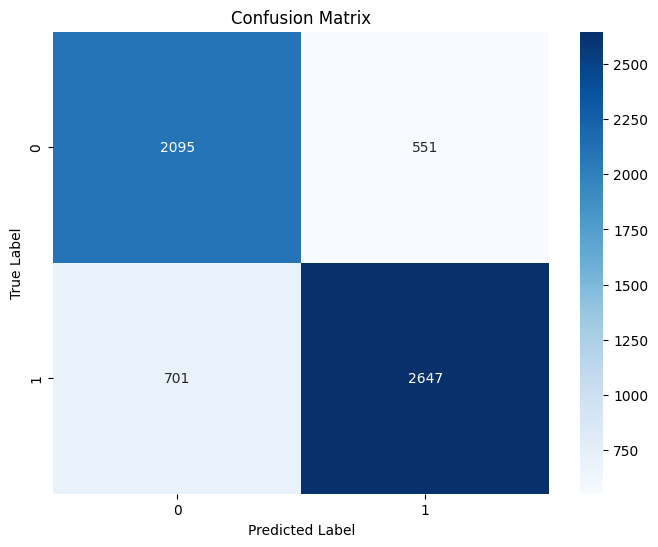

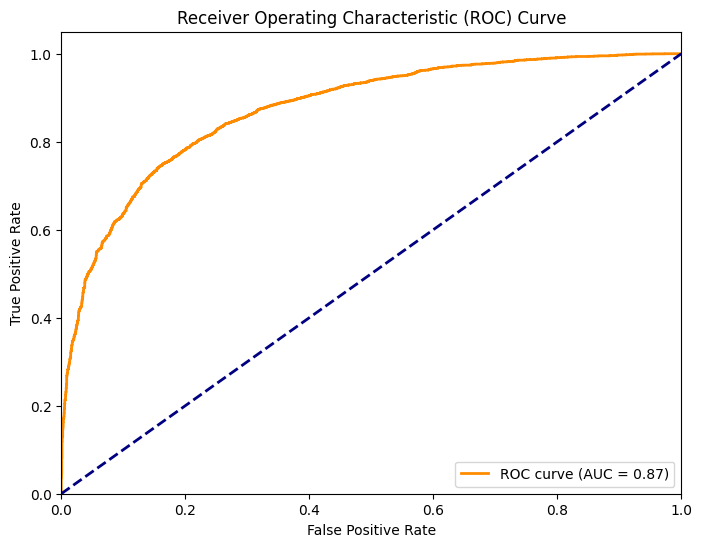

In [11]:
# Configurar MLflow
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment('Neural_Network_Model')

# Entrenar el modelo y registrar métricas
with mlflow.start_run(run_name="Toxic_Comments_Classification"):
    # Registrar parámetros
    mlflow.log_params({
        "dropout_rate": 0.3,
        "batch_size": 32,
        "max_features": 10000
    })
    
    # Medir tiempo de entrenamiento
    start_time = time.time()
    
    # Crear y entrenar el modelo
    model = create_model(X_train.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping]
    )
    
    training_time = time.time() - start_time
    
    # Evaluación del modelo
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
    
    # Calcular métricas detalladas
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    classification_rep = classification_report(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    
    # Calcular ROC y AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Registrar métricas en MLflow
    mlflow.log_metrics({
        "test_accuracy": test_accuracy,
        "test_loss": test_loss,
        "roc_auc": roc_auc,
        "training_time": training_time,
        "final_val_accuracy": history.history['val_accuracy'][-1],
        "final_val_loss": history.history['val_loss'][-1]
    })
    
    # Visualizar y guardar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    mlflow.log_artifact('confusion_matrix.png')
    
    # Visualizar y guardar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    mlflow.log_artifact('roc_curve.png')
    
    # Guardar el modelo
    mlflow.keras.log_model(model, "model")
    
    # Imprimir resultados
    print("\nModel Evaluation Results:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print("\nClassification Report:")
    print(classification_rep)

In [ ]:
# Importar pickle
import pickle

# Guardar el modelo en formato .pkl
with open('../Models/keraskeras_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# También guardar el vectorizador para futuros usos
with open('../Models/keras/keras_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)